## Table of Contents

1. Objectives
2. Data
3. Modeling
4. Conclusions
5. Appendix

## 1. Objectives

The report describes dataset, preparation and modeling done to predict taxi demands for Manhattan and the airports.

## 2. Data

The dataset used in yellow taxi trip dataset for January 2015. Due to huge size that cannot be processed by current computational power, I opt for smaller dataset as a sample to represent the whole 2015 dataset.

The data is checked for missing values and duplicates. I had taken out 6 regions from the Jan 2015 dataset that concentrate these areas which the client requested. 

I have analysed by grouping into dates according to each zone to explore duration, fare amount and passenger counts.

I have dropped unwanted features that are useless, created new features like duration, is Holiday, Day of Pickup and Demand as target. 

Statistical tests ANOVA and Chi-Square tests are performed to find out the p-values.

As for correlation, total amount is highly correlates with fare amount and tip amount.

Test train split is performed with 80% training and 20% testing.

## Modeling

The model will be multi-classification model since there are demand results are Low, Medium and High.

Two scenarios created:

1. Baseline Model

2. Tweaked Model to reduce false negatives in Low Demand

I used Logistic Regression and XGBoost for creating models in this project. Hyperparameter tuning is done for XGBoost.
There is no balancing of target feature done for demand. Crossvalidation is also done to ensure accuracy as a whole.

Metrics used are accuracy, recall, precision and F1-score.

## Conclusion

Both models gave perfect score for classifying taxi demand, hence logistic regression model is recommended for simplicity.

## Appendix: Code Section

### Modeling Tasks

Good work so far preparing the data to classify taxi demand and evaluating predictors. Now you can get started with the modeling! There are a couple scenarios to address below. As usual for classification modeling, you’ll need to report at least the following for each of your best/final models: 

- Accuracy
- Confusion matrix
- cMetrics output (or equivalent)

Scenario 1: 

Start off with a baseline model that emphasizes overall accuracy. Use your test data set to verify your modeling results. This model will be useful for analysis and comparison later. It may be also a good way to investigate model types and hyperparameters, class imbalance, and which features are most useful. 

Scenario 2 Main Points: 

- Emphasize reducing false negatives for Low demand, especially Low demand classified as High demand.
- Also, try to reduce false positives for Low, especially missed High.
- Some increase in false positives for Low demand is an acceptable trade-off to reduce false negatives for Low demand.
- Medium/High demand misclassification is not a priority to reduce.
- Use reasonable modifications to the cost matrix to achieve your goals. You’ll need to include a discussion of your customizations in your report. 
- Use your test data set to verify your modeling results. 

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier, ExtraTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, f_regression, chi2

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

np.random.seed(0)

from pycaret.classification import *

pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True)

### Data Exploration and Analysis

In [2]:
df = pd.read_csv("finaltrain2.csv")

In [3]:
df

,passenger_count,trip_distance,pickup_location,fare_amount,extra,tip_amount,total_amount,duration,pickupday,demand,isholiday,label
0,2,12.74,JFK Airport,47.5,0.5,9.60,58.40,24.0,29,low,0,1
1,1,17.50,JFK Airport,52.0,0.0,7.00,65.13,32.0,1,low,1,1
2,2,18.50,JFK Airport,51.0,0.5,0.00,57.63,30.0,18,low,0,1
3,1,14.80,JFK Airport,41.0,0.0,0.00,41.80,29.0,13,low,0,1
4,1,14.30,JFK Airport,39.5,0.5,0.00,40.80,22.0,29,low,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
68563,1,1.69,Upper East Side,8.0,0.0,0.00,8.80,8.0,10,low,0,1
68564,1,1.80,Upper East Side,12.5,0.0,2.00,15.30,18.0,3,low,0,1
68565,5,1.54,Upper East Side,7.5,1.0,1.70,11.00,7.0,15,high,0,0
68566,1,0.78,Upper East Side,5.5,1.0,1.25,8.55,5.0,15,low,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68568 entries, 0 to 68567
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  68568 non-null  int64  
 1   trip_distance    68568 non-null  float64
 2   pickup_location  68568 non-null  object 
 3   fare_amount      68568 non-null  float64
 4   extra            68568 non-null  float64
 5   tip_amount       68568 non-null  float64
 6   total_amount     68568 non-null  float64
 7   duration         68568 non-null  float64
 8   pickupday        68568 non-null  int64  
 9   demand           68568 non-null  object 
 10  isholiday        68568 non-null  int64  
 11  label            68568 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 6.3+ MB


In [5]:
df.describe(include='all')

,passenger_count,trip_distance,pickup_location,fare_amount,extra,tip_amount,total_amount,duration,pickupday,demand,isholiday,label
count,68568.000000,6.856800e+04,68568,68568.000000,68568.000000,68568.000000,68568.000000,68568.000000,68568.000000,68568,68568.000000,68568.000000
unique,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,Midtown,NaN,NaN,NaN,NaN,NaN,NaN,low,NaN,NaN
freq,NaN,NaN,39799,NaN,NaN,NaN,NaN,NaN,NaN,58036,NaN,NaN
mean,1.690424,5.194054e+01,NaN,13.839213,0.285746,1.760108,17.174227,14.549921,15.838000,NaN,0.058147,0.969578
std,1.346843,1.267113e+04,NaN,13.059612,0.365959,2.775889,16.001486,36.983077,8.716985,NaN,0.234022,0.390738
min,0.000000,0.000000e+00,NaN,-52.000000,-1.000000,0.000000,-52.800000,0.000000,1.000000,NaN,0.000000,0.000000
25%,1.000000,1.000000e+00,NaN,6.500000,0.000000,0.000000,8.160000,6.000000,8.000000,NaN,0.000000,1.000000
50%,1.000000,1.700000e+00,NaN,9.000000,0.000000,1.000000,11.300000,10.000000,15.000000,NaN,0.000000,1.000000
75%,2.000000,3.400000e+00,NaN,14.500000,0.500000,2.160000,17.800000,17.000000,23.000000,NaN,0.000000,1.000000


In [6]:
df.shape

(68568, 12)

In [7]:
df.columns

Index(['passenger_count', 'trip_distance', 'pickup_location', 'fare_amount', 'extra', 'tip_amount', 'total_amount', 'duration', 'pickupday', 'demand', 'isholiday', 'label'], dtype='object')

In [8]:
dfpickup = pd.get_dummies(data=df.pickup_location, drop_first=True)

In [9]:
dfpickup

,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
68563,0,0,0,1
68564,0,0,0,1
68565,0,0,0,1
68566,0,0,0,1


In [10]:
df2 = pd.concat([df,dfpickup],axis=1)

In [11]:
df2

,passenger_count,trip_distance,pickup_location,fare_amount,extra,tip_amount,total_amount,duration,pickupday,demand,isholiday,label,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side
0,2,12.74,JFK Airport,47.5,0.5,9.60,58.40,24.0,29,low,0,1,0,0,0,0
1,1,17.50,JFK Airport,52.0,0.0,7.00,65.13,32.0,1,low,1,1,0,0,0,0
2,2,18.50,JFK Airport,51.0,0.5,0.00,57.63,30.0,18,low,0,1,0,0,0,0
3,1,14.80,JFK Airport,41.0,0.0,0.00,41.80,29.0,13,low,0,1,0,0,0,0
4,1,14.30,JFK Airport,39.5,0.5,0.00,40.80,22.0,29,low,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68563,1,1.69,Upper East Side,8.0,0.0,0.00,8.80,8.0,10,low,0,1,0,0,0,1
68564,1,1.80,Upper East Side,12.5,0.0,2.00,15.30,18.0,3,low,0,1,0,0,0,1
68565,5,1.54,Upper East Side,7.5,1.0,1.70,11.00,7.0,15,high,0,0,0,0,0,1
68566,1,0.78,Upper East Side,5.5,1.0,1.25,8.55,5.0,15,low,0,1,0,0,0,1


In [12]:
df2.columns

Index(['passenger_count', 'trip_distance', 'pickup_location', 'fare_amount', 'extra', 'tip_amount', 'total_amount', 'duration', 'pickupday', 'demand', 'isholiday', 'label', 'LaGuardia Airport', 'Lower Manhattan', 'Midtown', 'Upper East Side'], dtype='object')

In [13]:
df2.drop(['pickup_location','label'],axis=1,inplace=True)

In [14]:
df2.head()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday,demand,isholiday,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side
0,2,12.74,47.5,0.5,9.6,58.40,24.0,29,low,0,0,0,0,0
1,1,17.50,52.0,0.0,7.0,65.13,32.0,1,low,1,0,0,0,0
2,2,18.50,51.0,0.5,0.0,57.63,30.0,18,low,0,0,0,0,0
3,1,14.80,41.0,0.0,0.0,41.80,29.0,13,low,0,0,0,0,0
4,1,14.30,39.5,0.5,0.0,40.80,22.0,29,low,0,0,0,0,0


In [15]:
df2.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'tip_amount', 'total_amount', 'duration', 'pickupday', 'demand', 'isholiday', 'LaGuardia Airport', 'Lower Manhattan', 'Midtown', 'Upper East Side'], dtype='object')

In [16]:
df2 = df2[['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'tip_amount', 
               'total_amount', 'duration', 'pickupday', 'isholiday', 'LaGuardia Airport', 
               'Lower Manhattan', 'Midtown', 'Upper East Side', 'demand' ]]

In [17]:
df2.head()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday,isholiday,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side,demand
0,2,12.74,47.5,0.5,9.6,58.40,24.0,29,0,0,0,0,0,low
1,1,17.50,52.0,0.0,7.0,65.13,32.0,1,1,0,0,0,0,low
2,2,18.50,51.0,0.5,0.0,57.63,30.0,18,0,0,0,0,0,low
3,1,14.80,41.0,0.0,0.0,41.80,29.0,13,0,0,0,0,0,low
4,1,14.30,39.5,0.5,0.0,40.80,22.0,29,0,0,0,0,0,low


### Data Visualization

### Univariate Data Exploration

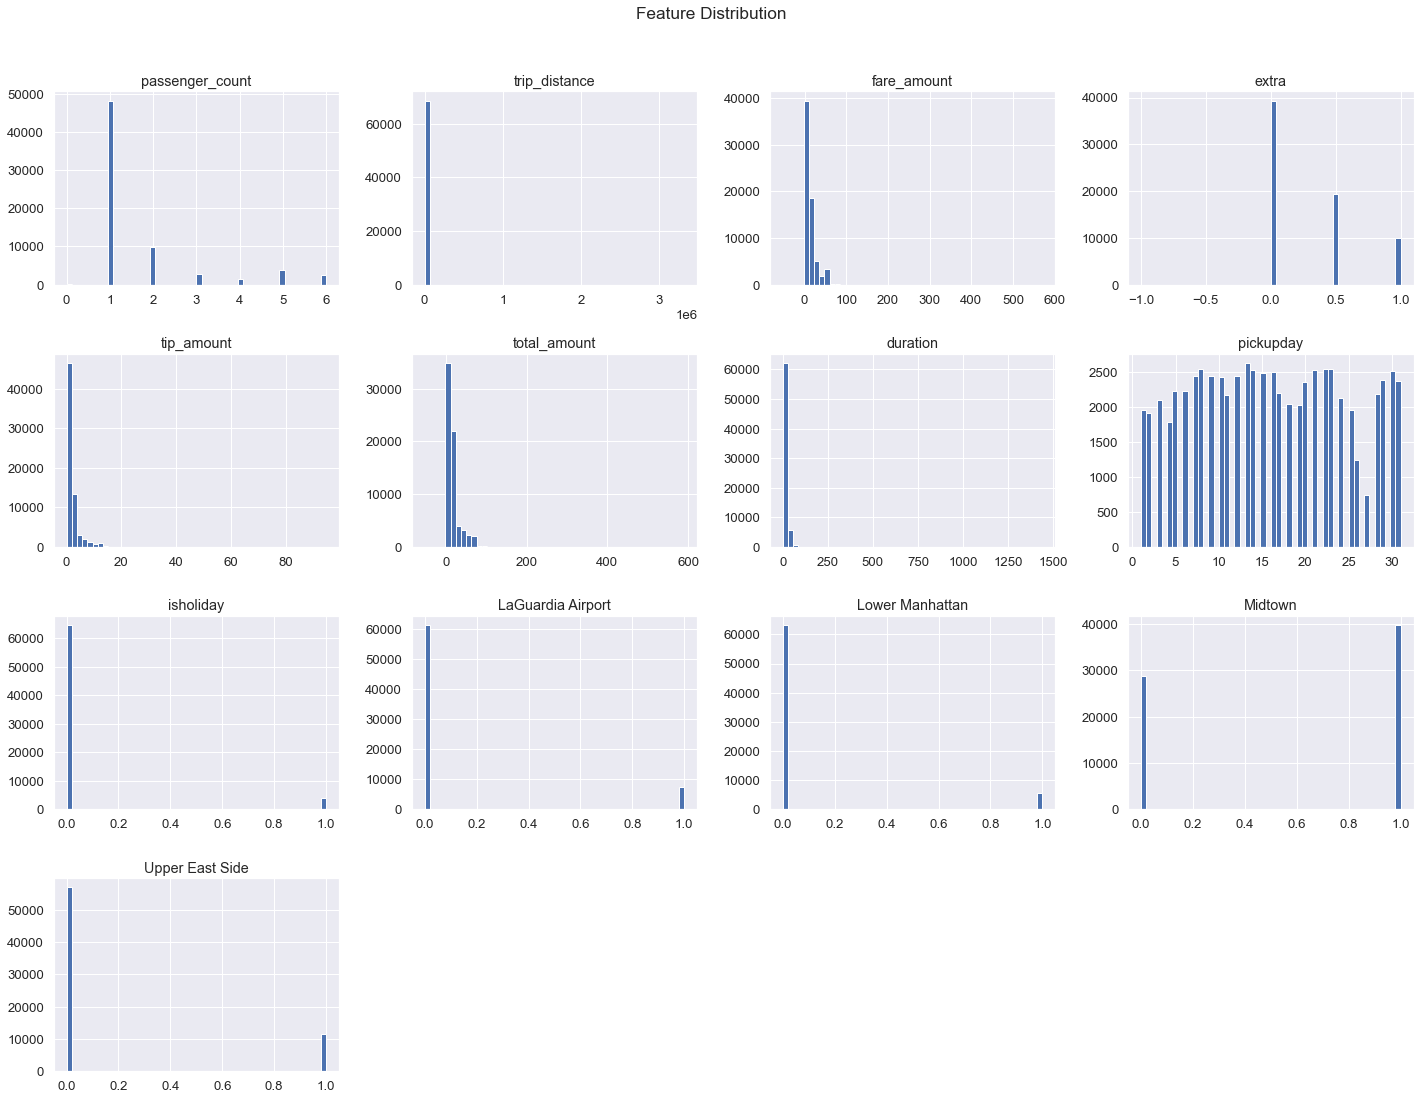

In [18]:
df2.hist(bins=50, figsize=(20,15))
plt.suptitle('Feature Distribution', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

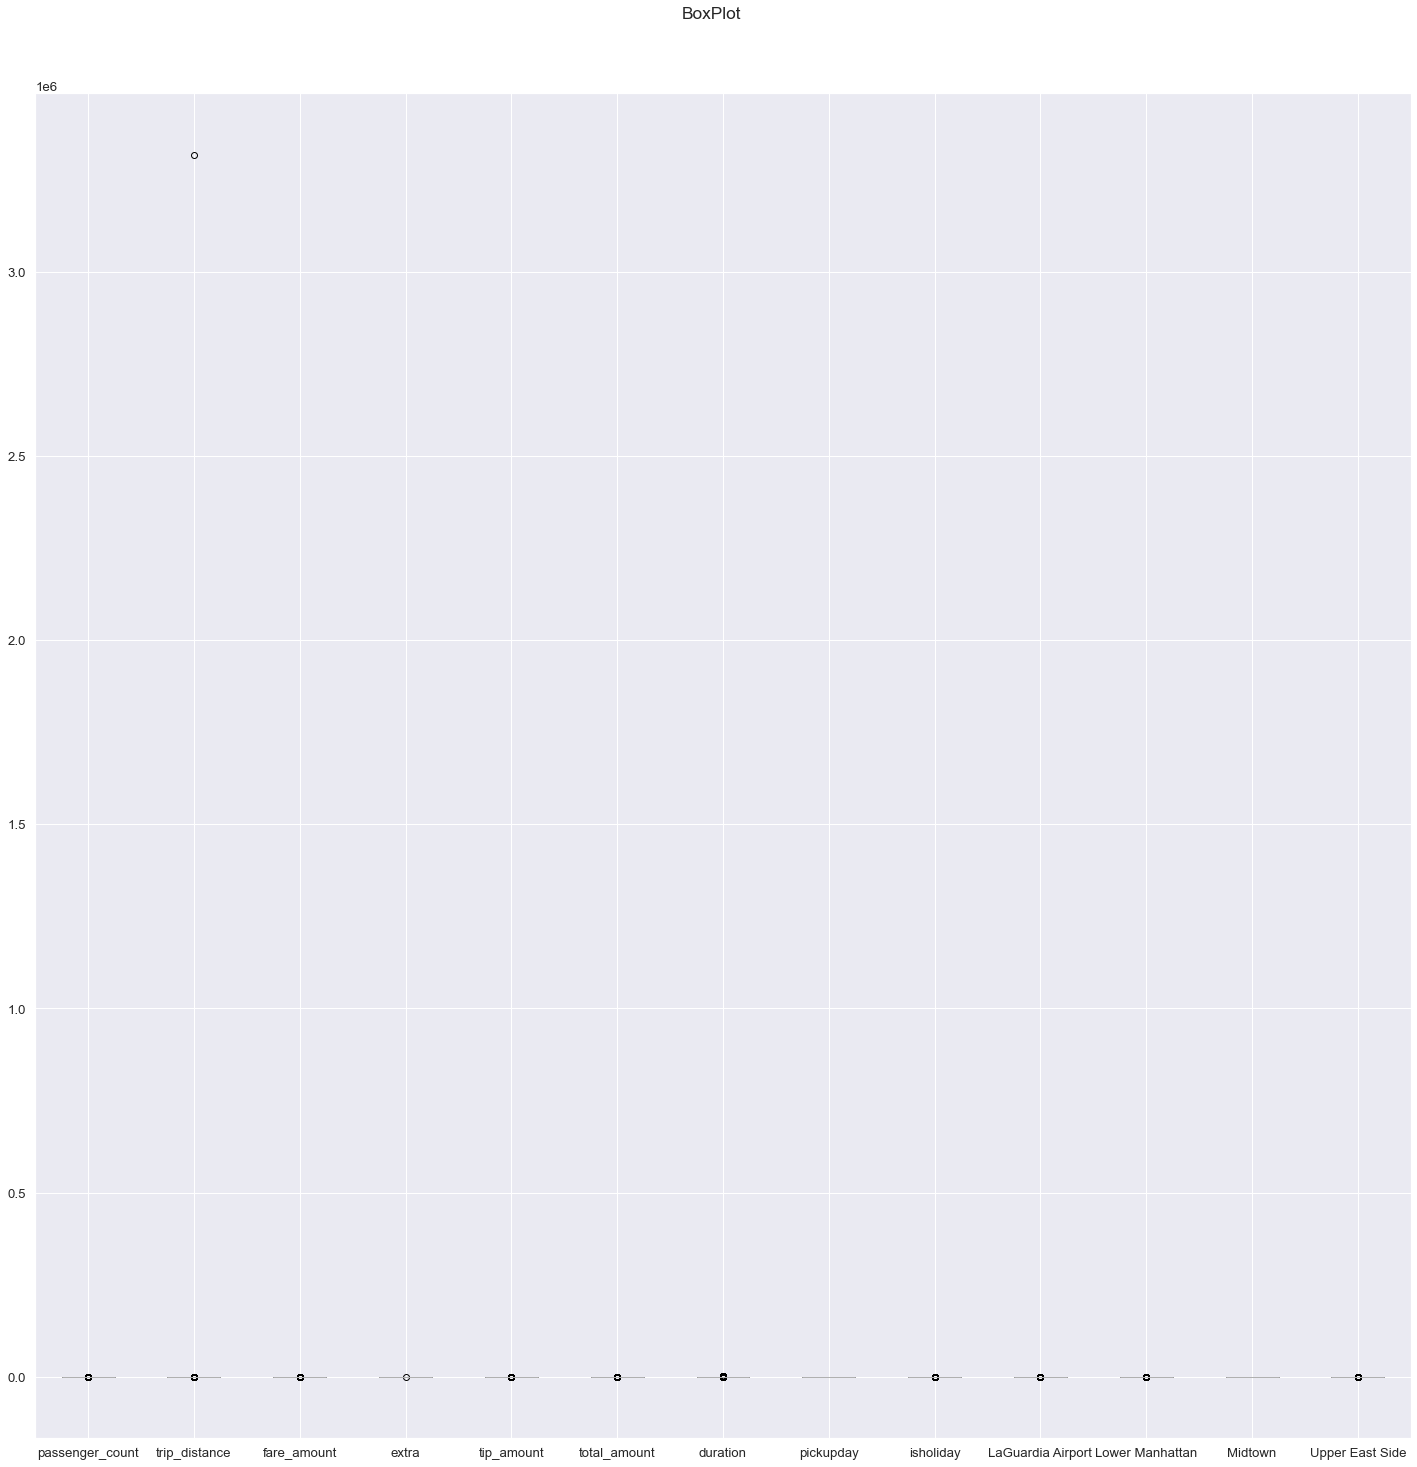

In [19]:
df2.boxplot(figsize=(20,20))
plt.suptitle('BoxPlot', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

### Correlation

In [20]:
df2.corr()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday,isholiday,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side
passenger_count,1.000000,-0.001952,0.013251,-0.004897,-0.009516,0.010623,0.015734,-0.012447,0.009499,0.005835,-0.006575,-0.007640,0.005656
trip_distance,-0.001952,1.000000,0.000253,-0.003012,0.002720,0.000517,0.000451,0.003563,-0.000938,-0.001355,-0.001139,0.003133,-0.001693
fare_amount,0.013251,0.000253,1.000000,-0.091227,0.604967,0.985443,0.261480,-0.021277,0.018778,-0.100120,-0.073609,-0.279646,0.071621
extra,-0.004897,-0.003012,-0.091227,1.000000,-0.034286,-0.066663,-0.026354,-0.005520,-0.069695,-0.008645,-0.016675,0.057144,0.007416
tip_amount,-0.009516,0.002720,0.604967,-0.034286,1.000000,0.715987,0.149022,0.014505,-0.000159,-0.058870,-0.060522,-0.170010,0.078581
total_amount,0.010623,0.000517,0.985443,-0.066663,0.715987,1.000000,0.255307,-0.016650,0.014982,-0.100853,-0.077941,-0.277848,0.088905
duration,0.015734,0.000451,0.261480,-0.026354,0.149022,0.255307,1.000000,0.004476,0.004844,-0.028464,-0.017849,-0.073539,0.023480
pickupday,-0.012447,0.003563,-0.021277,-0.005520,0.014505,-0.016650,0.004476,1.000000,-0.161067,0.012614,0.007767,0.004426,0.000890
isholiday,0.009499,-0.000938,0.018778,-0.069695,-0.000159,0.014982,0.004844,-0.161067,1.000000,0.002639,0.001484,-0.015934,0.004641
LaGuardia Airport,0.005835,-0.001355,-0.100120,-0.008645,-0.058870,-0.100853,-0.028464,0.012614,0.002639,1.000000,-0.100438,-0.405713,-0.155459


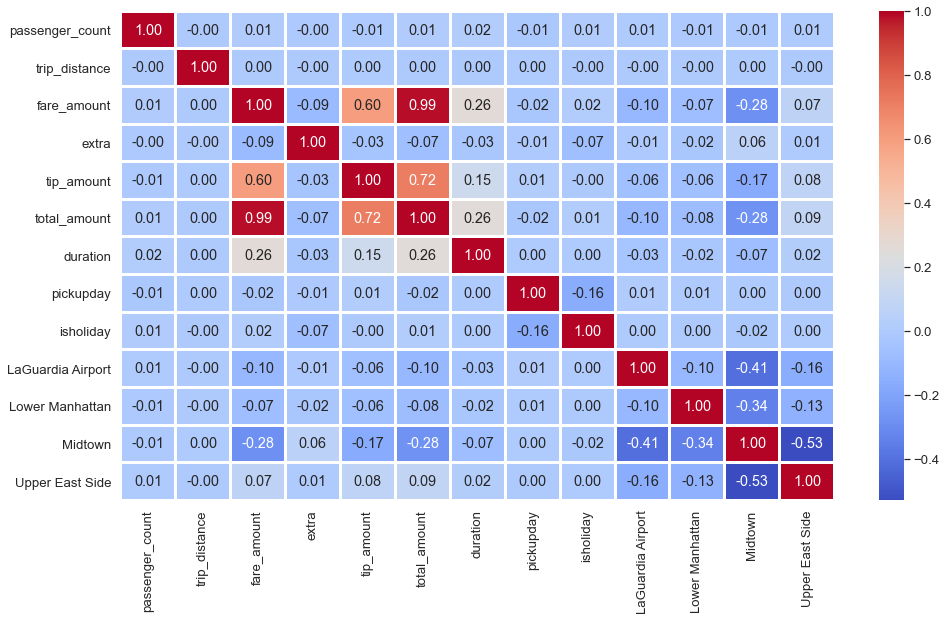

In [21]:
plt.figure(figsize=(16,9))
sns.heatmap(df2.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

### Treat Missing Values

In [22]:
df2.isnull().sum()

passenger_count      0
trip_distance        0
fare_amount          0
extra                0
tip_amount           0
total_amount         0
duration             0
pickupday            0
isholiday            0
LaGuardia Airport    0
Lower Manhattan      0
Midtown              0
Upper East Side      0
demand               0
dtype: int64

### Treat Duplicate Values

In [23]:
df2.duplicated(keep='first').sum()

1128

In [24]:
df2[df2.duplicated(keep=False)] #Check duplicate values

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday,isholiday,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side,demand
722,1,0.0,2.5,0.0,0.0,3.30,0.0,18,0,0,0,0,0,low
820,1,0.0,2.5,0.0,0.0,3.30,0.0,18,0,0,0,0,0,low
823,1,18.7,52.0,0.0,0.0,58.13,52.0,12,0,0,0,0,0,low
3831,1,18.7,52.0,0.0,0.0,58.13,52.0,12,0,0,0,0,0,low
3887,1,0.0,2.5,0.0,0.0,3.30,0.0,18,0,0,0,0,0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68185,1,1.4,6.5,0.0,1.0,8.30,5.0,15,0,0,0,0,1,low
68297,3,1.1,6.5,0.0,0.0,7.30,6.0,10,0,0,0,0,1,medium
68449,1,1.1,5.5,0.5,0.0,6.80,4.0,4,0,0,0,0,1,low
68459,1,1.2,6.0,0.5,0.0,7.30,5.0,24,0,0,0,0,1,low


In [25]:
df2.drop_duplicates(ignore_index=True, inplace=True)

In [26]:
df2.duplicated(keep='first').sum()

0

In [27]:
df2.shape

(67440, 14)

### Treat Outliers

In [28]:
df2.describe()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday,isholiday,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side
count,67440.000000,6.744000e+04,67440.000000,67440.000000,67440.000000,67440.000000,67440.000000,67440.000000,67440.000000,67440.000000,67440.000000,67440.000000,67440.000000
mean,1.700964,5.279263e+01,13.966014,0.287745,1.784418,17.335439,14.686907,15.836225,0.058170,0.107458,0.079167,0.575504,0.170552
std,1.354785,1.277665e+04,13.127648,0.366618,2.791333,16.081857,37.273105,8.718419,0.234067,0.309698,0.270001,0.494270,0.376119
min,0.000000,0.000000e+00,-52.000000,-1.000000,0.000000,-52.800000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000e+00,6.500000,0.000000,0.000000,8.300000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.720000e+00,9.000000,0.000000,1.000000,11.400000,10.000000,15.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2.000000,3.420000e+00,15.000000,0.500000,2.200000,17.800000,17.000000,23.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,6.000000,3.318000e+06,570.080000,1.000000,94.510000,590.380000,1440.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Treat Data Types

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67440 entries, 0 to 67439
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   passenger_count    67440 non-null  int64  
 1   trip_distance      67440 non-null  float64
 2   fare_amount        67440 non-null  float64
 3   extra              67440 non-null  float64
 4   tip_amount         67440 non-null  float64
 5   total_amount       67440 non-null  float64
 6   duration           67440 non-null  float64
 7   pickupday          67440 non-null  int64  
 8   isholiday          67440 non-null  int64  
 9   LaGuardia Airport  67440 non-null  uint8  
 10  Lower Manhattan    67440 non-null  uint8  
 11  Midtown            67440 non-null  uint8  
 12  Upper East Side    67440 non-null  uint8  
 13  demand             67440 non-null  object 
dtypes: float64(6), int64(3), object(1), uint8(4)
memory usage: 5.4+ MB


### Create and save processed dataset

In [30]:
#df2.to_csv("finaltrain3.csv",index=False)

### Train Test Split

In [31]:
df = pd.read_csv("finaltrain3.csv")

In [32]:
df.shape

(67440, 14)

In [33]:
df.head()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday,isholiday,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side,demand
0,2,12.74,47.5,0.5,9.6,58.40,24.0,29,0,0,0,0,0,low
1,1,17.50,52.0,0.0,7.0,65.13,32.0,1,1,0,0,0,0,low
2,2,18.50,51.0,0.5,0.0,57.63,30.0,18,0,0,0,0,0,low
3,1,14.80,41.0,0.0,0.0,41.80,29.0,13,0,0,0,0,0,low
4,1,14.30,39.5,0.5,0.0,40.80,22.0,29,0,0,0,0,0,low


In [34]:
df["demand"].value_counts()

low       56917
high       6304
medium     4219
Name: demand, dtype: int64

In [35]:
le = LabelEncoder()

In [36]:
df["demand"] = le.fit_transform(df["demand"])

In [37]:
df.head()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday,isholiday,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side,demand
0,2,12.74,47.5,0.5,9.6,58.40,24.0,29,0,0,0,0,0,1
1,1,17.50,52.0,0.0,7.0,65.13,32.0,1,1,0,0,0,0,1
2,2,18.50,51.0,0.5,0.0,57.63,30.0,18,0,0,0,0,0,1
3,1,14.80,41.0,0.0,0.0,41.80,29.0,13,0,0,0,0,0,1
4,1,14.30,39.5,0.5,0.0,40.80,22.0,29,0,0,0,0,0,1


In [38]:
df["demand"].value_counts()  # Low = 1; Medium = 2, High = 0

1    56917
0     6304
2     4219
Name: demand, dtype: int64

In [39]:
#df.to_csv("finaltrain4.csv",index=False)

In [40]:
X = df.iloc[:,0:13]
y = df.iloc[:,13]

In [41]:
X.values, y.values

(array([[ 2.  , 12.74, 47.5 , ...,  0.  ,  0.  ,  0.  ],
        [ 1.  , 17.5 , 52.  , ...,  0.  ,  0.  ,  0.  ],
        [ 2.  , 18.5 , 51.  , ...,  0.  ,  0.  ,  0.  ],
        ...,
        [ 5.  ,  1.54,  7.5 , ...,  0.  ,  0.  ,  1.  ],
        [ 1.  ,  0.78,  5.5 , ...,  0.  ,  0.  ,  1.  ],
        [ 1.  ,  1.01,  7.  , ...,  0.  ,  0.  ,  1.  ]]),
 array([1, 1, 1, ..., 0, 1, 1]))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((53952, 13), (13488, 13), (53952,), (13488,))

### Feature Scaling

In [44]:
X_train

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday,isholiday,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side
66137,1,9.79,30.0,0.0,8.83,44.96,24.0,13,0,0,0,0,1
41743,1,1.28,6.5,1.0,0.00,8.30,6.0,20,0,0,0,1,0
12199,1,0.80,5.0,1.0,1.35,8.15,5.0,21,0,0,1,0,0
9707,1,4.12,18.5,0.0,2.00,21.30,25.0,31,0,1,0,0,0
22540,1,0.55,4.5,0.5,1.50,7.30,4.0,5,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41993,1,1.49,8.5,0.0,2.79,12.09,11.0,30,0,0,0,1,0
21243,1,3.53,13.5,0.0,2.00,16.30,17.0,28,0,0,0,1,0
45891,2,0.50,5.5,0.0,1.25,7.55,6.0,10,0,0,0,1,0
42613,1,4.00,14.0,0.5,0.00,15.30,10.0,21,0,0,0,1,0


In [45]:
minmax = MinMaxScaler()

In [46]:
X_train_scaled = minmax.fit_transform(X_train)

In [47]:
X_test_scaled = minmax.transform(X_test)

In [48]:
X_train_scaled

array([[0.16666667, 0.00000295, 0.13181584, ..., 0.        , 0.        ,
        1.        ],
       [0.16666667, 0.00000039, 0.09403935, ..., 0.        , 1.        ,
        0.        ],
       [0.16666667, 0.00000024, 0.09162809, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.33333333, 0.00000015, 0.09243184, ..., 0.        , 1.        ,
        0.        ],
       [0.16666667, 0.00000121, 0.10609568, ..., 0.        , 1.        ,
        0.        ],
       [0.16666667, 0.00000075, 0.10288066, ..., 0.        , 1.        ,
        0.        ]])

In [49]:
X_test_scaled

array([[0.5       , 0.00000579, 0.16718107, ..., 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.00000036, 0.0932356 , ..., 0.        , 1.        ,
        0.        ],
       [0.33333333, 0.00000058, 0.09805813, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.16666667, 0.00000527, 0.16718107, ..., 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.00000043, 0.09484311, ..., 0.        , 1.        ,
        0.        ],
       [0.16666667, 0.00000096, 0.10689943, ..., 0.        , 0.        ,
        0.        ]])

### Model Training

### Using PyCaret

In [50]:
exp = setup(data = df, target = 'demand', session_id=0, normalize=True, 
            train_size= 0.8,normalize_method='minmax',
            categorical_features=['LaGuardia Airport','Lower Manhattan','Midtown','Upper East Side'],
            numeric_features=['passenger_count']
           )

,Description,Value
0,session_id,0
1,Target,demand
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(67440, 14)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [51]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,pycaret.internal.tunable.TunableMLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [52]:
compare_models(exclude=['catboost','lightgbm','lda','qda','mlp','nb','ridge'],fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.0980
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0800
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0880
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9680
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,8.0040
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9800
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.0520
knn,K Neighbors Classifier,0.9990,0.9999,0.9947,0.9990,0.9990,0.9963,0.9963,3.4880
svm,SVM - Linear Kernel,0.9729,0.0000,0.8556,0.9751,0.9629,0.8896,0.8962,0.1840


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
logistic = create_model('lr', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Mean,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
SD,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


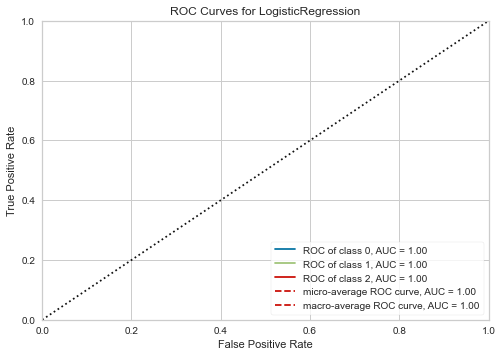

In [54]:
plot_model(logistic)

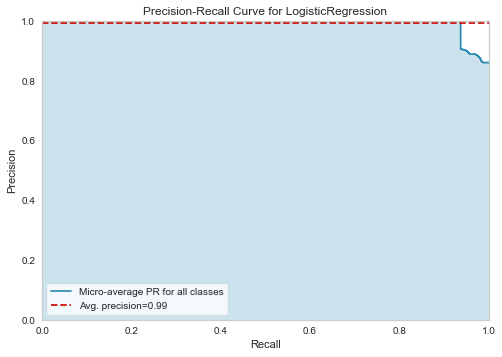

In [55]:
plot_model(logistic, plot='pr')

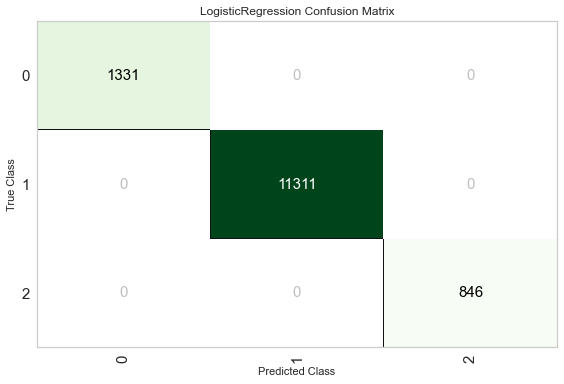

In [56]:
plot_model(logistic, plot='confusion_matrix')

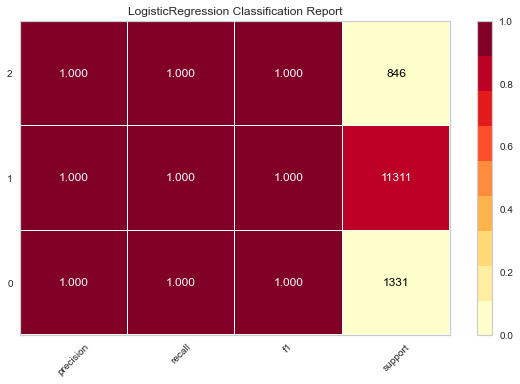

In [57]:
plot_model(logistic, plot='class_report')

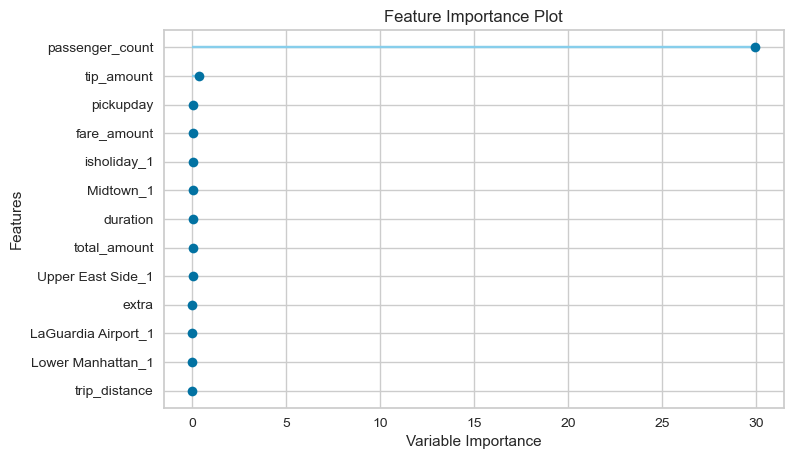

In [58]:
plot_model(logistic, plot='feature_all')

### Using Classification Models (Model 1)

In [59]:
lr = LogisticRegression(random_state=0)

In [60]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
lr_pred = lr.predict(X_test_scaled)

In [62]:
lr_pred

array([2, 1, 1, ..., 1, 1, 1])

### Model Evaluation

In [63]:
cm = confusion_matrix(y_test,lr_pred)
cm

array([[ 1331,     0,     0],
       [    0, 11311,     0],
       [    0,     0,   846]], dtype=int64)

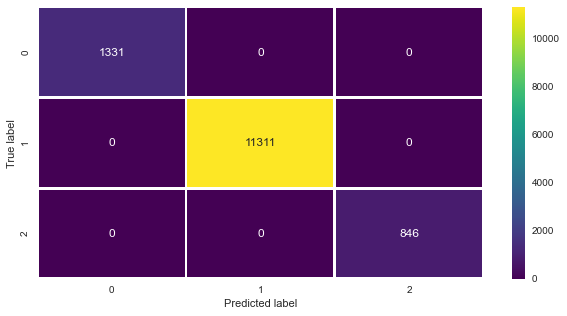

In [64]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='d',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [65]:
print(classification_report(y_test,lr_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1331
           1       1.00      1.00      1.00     11311
           2       1.00      1.00      1.00       846

    accuracy                           1.00     13488
   macro avg       1.00      1.00      1.00     13488
weighted avg       1.00      1.00      1.00     13488



In [66]:
accuracy_score(y_test,lr_pred)

1.0

### Using XGBoost (Scikit-Learn)

### Using RandomSearchCV

In [67]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='softmax:multi')

In [68]:
parameters = {'max_depth': np.arange(3,10,1),
              'eta': np.arange(0.05,0.3,0.05),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,10,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1),
              'reg_alpha':np.arange(0,1,0.1),
              'reg_lambda':np.arange(0,1,0.1)
             }

In [69]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 10, 
                           n_jobs=-1, scoring='accuracy')

In [70]:
randm.fit(X_train_scaled, y_train)

[18:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                        'min_child_weight': array([1, 2, 3]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800,

In [71]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.1, gamma=8,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.0,
              reg_lambda=0.30000000000000004, scale_pos_weight=None,
              subsample=0.7999999999999999, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [72]:
randm.best_score_

1.0

In [73]:
randm.best_params_

{'subsample': 0.7999999999999999,
 'reg_lambda': 0.30000000000000004,
 'reg_alpha': 0.0,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 6,
 'gamma': 8,
 'eta': 0.1,
 'colsample_bytree': 0.7}

### Final Model (Model 2)

In [74]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='softmax:multi', 
                         subsample=0.8,reg_lambda =0.3, reg_alpha = 0.0, min_child_weight = 3,
                         max_depth = 6, gamma = 8, eta = 0.1, colsample_bytree = 0.7)

In [75]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='mlogloss',early_stopping_rounds=10)

[0]	validation_0-mlogloss:0.96692
[1]	validation_0-mlogloss:0.85754
[2]	validation_0-mlogloss:0.76518
[3]	validation_0-mlogloss:0.67478
[4]	validation_0-mlogloss:0.59729
[5]	validation_0-mlogloss:0.53932
[6]	validation_0-mlogloss:0.48857
[7]	validation_0-mlogloss:0.44392
[8]	validation_0-mlogloss:0.40212
[9]	validation_0-mlogloss:0.37274
[10]	validation_0-mlogloss:0.33342
[11]	validation_0-mlogloss:0.29865
[12]	validation_0-mlogloss:0.27235
[13]	validation_0-mlogloss:0.24439
[14]	validation_0-mlogloss:0.22382
[15]	validation_0-mlogloss:0.20116
[16]	validation_0-mlogloss:0.18785
[17]	validation_0-mlogloss:0.17263
[18]	validation_0-mlogloss:0.15822
[19]	validation_0-mlogloss:0.14247
[20]	validation_0-mlogloss:0.13378
[21]	validation_0-mlogloss:0.12055
[22]	validation_0-mlogloss:0.11107
[23]	validation_0-mlogloss:0.10015
[24]	validation_0-mlogloss:0.09034
[25]	validation_0-mlogloss:0.08348
[26]	validation_0-mlogloss:0.07864
[27]	validation_0-mlogloss:0.07098
[28]	validation_0-mlogloss:0.0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.1, gamma=8,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.0,
              reg_lambda=0.3, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [76]:
y_pred = xgbmodel.predict(X_test_scaled)

In [77]:
y_pred

array([2, 1, 1, ..., 1, 1, 1])

### Model Evaluation

In [78]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[ 1331,     0,     0],
       [    0, 11311,     0],
       [    0,     0,   846]], dtype=int64)

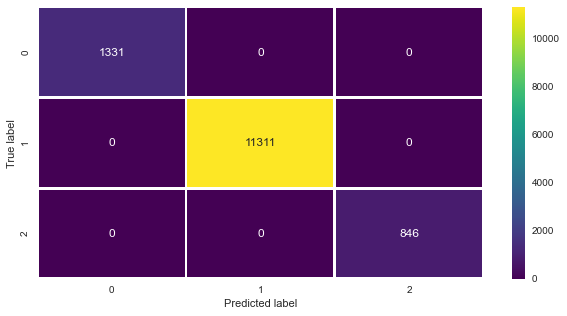

In [79]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='d',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1331
           1       1.00      1.00      1.00     11311
           2       1.00      1.00      1.00       846

    accuracy                           1.00     13488
   macro avg       1.00      1.00      1.00     13488
weighted avg       1.00      1.00      1.00     13488



### The permutation based importance

In [81]:
perm_importance = permutation_importance(xgbmodel,X_test_scaled,y_test, random_state=0, scoring='accuracy')

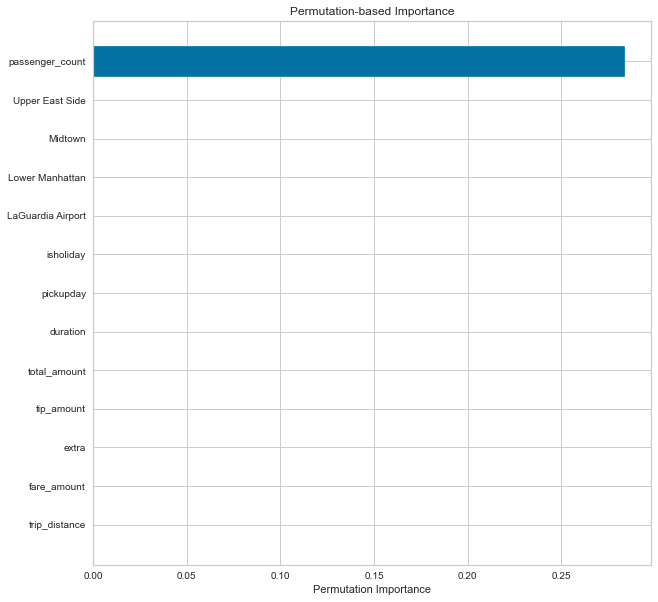

In [82]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,10))
plt.title("Permutation-based Importance")
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

### Compute Importance from SHAP Values

In [83]:
explainer = shap.TreeExplainer(xgbmodel)

In [84]:
shap_values = explainer.shap_values(X_test_scaled)

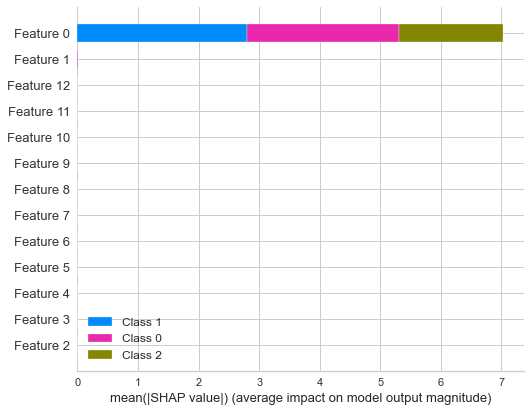

In [85]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

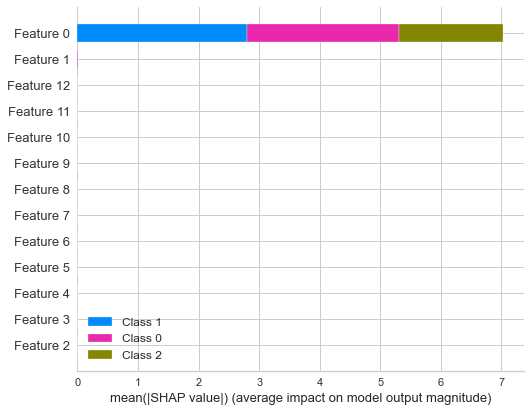

In [86]:
shap.summary_plot(shap_values, X_test_scaled)

### XGBoost Importance

In [87]:
X.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'tip_amount', 'total_amount', 'duration', 'pickupday', 'isholiday', 'LaGuardia Airport', 'Lower Manhattan', 'Midtown', 'Upper East Side'], dtype='object')

In [88]:
xgbmodel.get_booster().feature_names = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'tip_amount', 'total_amount', 'duration', 'pickupday', 'isholiday', 'LaGuardia Airport', 'Lower Manhattan', 'Midtown', 'Upper East Side']

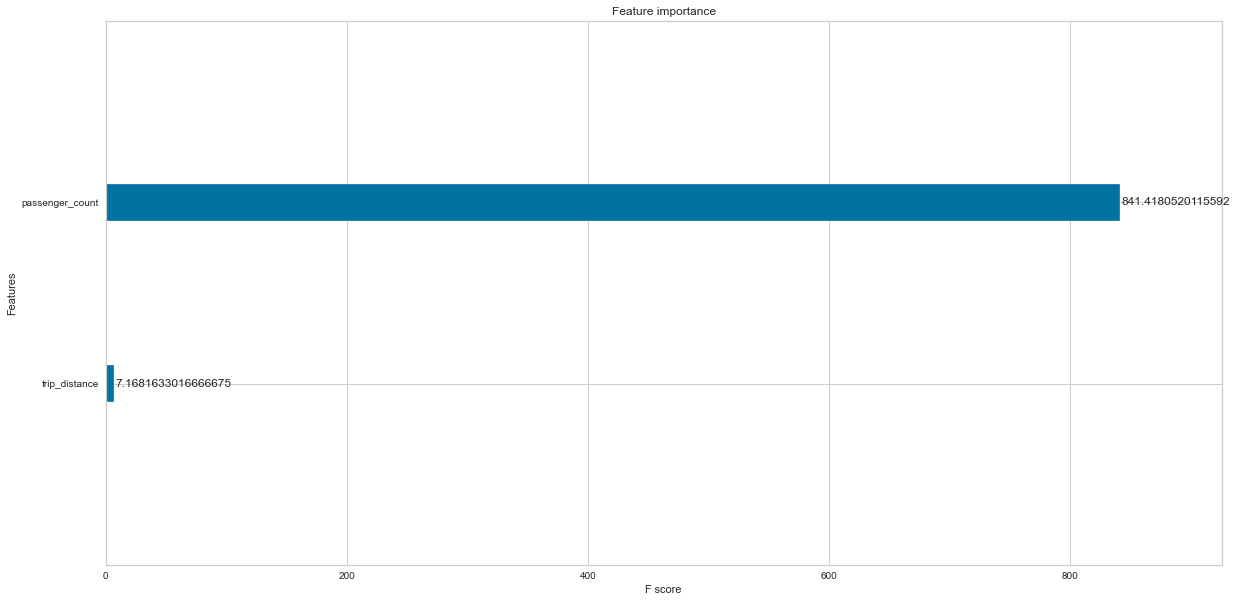

In [91]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax, importance_type='gain')
plt.show()

### Cross-Validation

In [92]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:56:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.8s finished


In [93]:
cv.mean()

1.0

### Save the Model

In [94]:
filename = 'taximodel.sav'
dump(lr,open(filename,'wb'))

### Load the Model

In [95]:
loaded_model = load(open(filename,'rb'))

In [96]:
loaded_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)